In [1]:
import json
import os
from openpyxl import load_workbook
from datetime import timedelta
import random
from copy import deepcopy
from django.contrib.gis.geos import LineString, Point
from django.contrib.admin.utils import flatten
import math
import datetime
import locale
from tqdm.notebook import tqdm
from PIL import Image
from io import BytesIO
from django.contrib.gis.geos import Point, LineString as DjangoLineString
import pytz

In [2]:
from simple_history.utils import bulk_create_with_history
from helpers.histories import bulk_update_with_history
from openpyxl_image_loader import SheetImageLoader

In [3]:
from helpers.route_maker import dic_to_ordered_list, unequal_point_pairs

In [4]:
def km_to_coordinates(road, km):

    road_marks = dic_to_ordered_list(road.marks)
    selected_pair = None

    for pair in unequal_point_pairs(road_marks):
        if pair[0]["km"] > km and pair[1]["km"] < km:
            selected_pair = pair
            break
        elif pair[1]["km"] > km and pair[0]["km"] < km:
            selected_pair = pair
            break
        elif pair[0]["km"] == km:
            return Point(pair[0]["point"]["coordinates"]), road
        elif pair[1]["km"] == km:
            return Point(pair[1]["point"]["coordinates"]), road

    # Calculate total length
    start_km = min([selected_pair[0]["km"], selected_pair[1]["km"]])
    end_km = max([selected_pair[0]["km"], selected_pair[1]["km"]])
    segment_mark_length = end_km - start_km
    distance_from_min = km - start_km
    # Check if km is decreasing
    invert_km = selected_pair[1]["km"] <= selected_pair[0]["km"]

    # Cut segment
    start_key = min((selected_pair[0]["index"], selected_pair[1]["index"]))
    end_key = max((selected_pair[0]["index"], selected_pair[1]["index"]))

    points = []
    for key in range(start_key, end_key + 1):
        points.append(
            Point(road.path[key][0], road.path[key][1], road.path[key][2])
        )

    segment = LineString(points, srid=4326)
    # Apply km inversion correction
    if invert_km:
        segment_distance = (
            1 - (distance_from_min / segment_mark_length)
        ) * segment.length
    else:
        segment_distance = (
            distance_from_min / segment_mark_length
        ) * segment.length
    # Find point
    point = segment.interpolate(segment_distance)

    return Point(point.x, point.y), road

In [5]:
def check_valid_road(road, km):

    road_marks = dic_to_ordered_list(road.marks)

    for pair in unequal_point_pairs(road_marks):
        if pair[0]["km"] >= km and pair[1]["km"] <= km:
            return True
        elif pair[1]["km"] >= km and pair[0]["km"] <= km:
            return True

    return False

In [6]:
def get_road_coordinates(road_name, km, direction, company):
    road_set = Road.objects.filter(
        name__contains=road_name, direction=int(direction), company=company
    )
#     print(road_set)

    # If roads in specified direction are not found, search road only
    # by name and order then by direction
    road_set_generic = Road.objects.filter(
        name__contains=road_name, company=company
    ).order_by("direction")

    # Check if KM range in road_set
#     print("Searching KM on direction...")
    valid = False
    for road in road_set:
        if check_valid_road(road, km):
#             print("Found KM on Road {}".format(road))
            valid = True
            break

    if not valid:
#         print("Searching KM without direction...")
        for road in road_set_generic:
            if check_valid_road(road, km):
#                 print("Found KM on Road {}".format(road))
                valid = True
                break

    if not valid:
        return Point(0, 0), None

    try:
        return km_to_coordinates(road, km)
    except Exception:
        return Point(0, 0), None

In [7]:
def get_connected_reference(company, resource, key, value):
    value=value.strip()
    select_options = company.custom_options[resource]['fields'][key]['selectOptions']['options']
    return next(a['value'] for a in select_options if a['name'].lower() == value.lower())

In [8]:
def get_value(field, occ, value):
    values = occ.form_fields['fields']
    item_translation = flatten([item['selectOptions']['options'] for item in values if item['displayName']==field])
#     print(item_translation)
    if field == 'Nome da placa':
        value=value.upper()
    final_translation = {item['name']: item['value'] for item in item_translation}
#     print(final_translation)
    return final_translation[value]

In [9]:
def get_sign(field, sign_field, occ, value):
    if sign_field == 'Cor':
        value=value.capitalize()
    elif sign_field == 'Tipo de Película':
        value=value.split(' ')[1]
    values = occ.form_fields['fields']
    item_translation = flatten([item['innerFields'] for item in values if item['displayName']==field])
#     print(item_translation)
    mid_translation = flatten([item['selectOptions']['options'] for item in item_translation if item['displayName'] == sign_field])
#     print(mid_translation)
    final_translation = {item['name']: item['value'] for item in mid_translation}
#     print(final_translation)
    return final_translation[value]

In [10]:
!cat .env

STAGE=PRODUCTION


In [11]:
filename = "Template - SP-293 - ok - Rev.01"

In [12]:
wb = load_workbook(filename + '.xlsx')
sheetname = wb.sheetnames[0]
# sheetname
ws = wb[sheetname]
wb.sheetnames, ws

(['Sinalização vertical'], <Worksheet "Sinalização vertical">)

In [13]:
image_loader = SheetImageLoader(ws)

for index, row in enumerate(ws.rows):
    if index == 0:
        continue
    
    if row[0].value is not None:
        
        try:
            image = image_loader.get('Y' + str(index+1))
            image2 = image_loader.get('Z' + str(index+1))
        except:
            print(row[0])

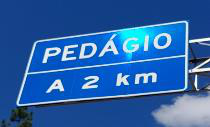

In [14]:
image2

In [15]:
header = []
values = []

for index, row in enumerate(ws.rows):
    if index == 0:
        header = list([a.value for a in row])
        continue
    obj = {}
    for col_index, cell in enumerate(row):
        value = cell.value
        obj[header[col_index]] = value
    
    if obj['Rodovia'] is not None:           
   
        obj['img'] = [a for a in ws._images if a.anchor._from.row == index]

        try:
            obj['img'][0].name='Verso'
        except:
            pass

        try:
            obj['img'][1].name='Frente'
        except:
            pass

        
        values.append(obj)

In [16]:
company = Company.objects.get(name='Eixo SP')

occurrence_type=OccurrenceType.objects.get(uuid='ff9f0674-fdc9-48a7-99b3-0f5a3302160a')
user=User.objects.get(username='rlcs')

sign_name='Adicionar Retrorrefletância de película'
company,occurrence_type,user

(<Company: 097fe80a-4917-4fa1-8207-2de35c113599: Eixo SP>,
 <OccurrenceType: Sinalização vertical - ['Eixo SP']>,
 <User: rlcs - Kartado CS>)

In [17]:
for a in tqdm(values):
    a['Películas'] = list(filter(None, [{'color': get_sign(sign_name, 'Cor', occurrence_type, a['cor 1']), 'type_of_film': get_sign(sign_name, 'Tipo de Película', occurrence_type, a['tipo de película 1'])},
                      {'color': get_sign(sign_name, 'Cor', occurrence_type, a['cor 2']), 'type_of_film': get_sign(sign_name, 'Tipo de Película', occurrence_type, a['tipo de película 2'])} if a['cor 2'] != '' and a['cor 2'] != '-' and a['cor 2'] is not None else None,
                      {'color': get_sign(sign_name, 'Cor', occurrence_type, a['cor 3']), 'type_of_film': get_sign(sign_name, 'Tipo de Película', occurrence_type, a['tipo de película 3'])} if a['cor 3'] != '' and a['cor 3'] != '-' and a['cor 3'] is not None else None,
                      {'color': get_sign(sign_name, 'Cor', occurrence_type, a['cor 4']), 'type_of_film': get_sign(sign_name, 'Tipo de Película', occurrence_type, a['tipo de película 4'])} if a['cor 4'] != '' and a['cor 4'] != '-' and a['cor 4'] is not None else None]))

  0%|          | 0/865 [00:00<?, ?it/s]

In [18]:
len(values)

865

In [19]:
float(values[2]['km'].replace('+','.')),values[2]['km']

(16.17, '016+170')

In [20]:
objects=[]

for index, a in enumerate(tqdm(values)):

    point, road = get_road_coordinates(a['Rodovia'], float(a['km'].replace('+','.')), str(get_connected_reference(company, 'reporting', 'direction', a['Sentido'].capitalize())) , company)

    try:
        objects.append((Reporting(
                    company=company,
                    occurrence_type=occurrence_type,
                    lane=get_connected_reference(company, 'reporting', 'lane', a['Faixa']),
                    road=road,
                    road_name=road.name,
                    direction=get_connected_reference(company, 'reporting', 'direction', a['Sentido'].capitalize()),
                    created_by=user,
                    km=float(a['km'].replace('+','.')),
                    end_km=a['km final'],
                    point=point,
                    form_data={
                        'position': get_value('Posição', occurrence_type, a['Posição'].strip().capitalize()),
                        'sign_name': get_value('Nome da placa', occurrence_type, a['Nome da placa'].title().strip().replace(' /', '/').replace("M.A..","M.A.").replace('Atrativos Turístico','ATRATIVO TURÍSTICO').replace('A-42A Composta','A-42A/COMPOSTA').replace('R-19 Composta','R-19/COMPOSTA')) if type(a['Nome da placa']) == str else None,
                        'sign_type': get_value('Tipo da placa', occurrence_type, a['Tipo da placa'].title().strip().replace("Atrativos Turístico","Atrativos Turísticos").replace("ATRATIVOS TURÍSTICO","Atrativos Turísticos").replace("Atrativo Turístico","Atrativos Turísticos")) if a['Tipo da placa'] else None,
                        'width': a['Largura (m)'] if a['Largura (m)'] is not None else None,
                        'height': a['Altura (m)'] if a['Altura (m)'] is not None else None,
                        'manufacture_date': a['Data de fabricação'].strftime('%Y-%m-%dT03:00:00.000Z') if a['Data de fabricação'] and a['Data de fabricação'] != ' ' else None,
                        'ra': a['RA'] if ((a['RA']) and (a['RA'] != ' ')) else None,
                        'retro': a['Películas'] if 'Películas' in a else None,
                        'plate_type': get_value('Tipo de Chapa', occurrence_type, a['Tipo de Chapa'].replace('Aço Galvanizado Galvanizado','Aço Galvanizado')) if a['Tipo de Chapa'] else None,
                        'plate_condition': get_value('Condição da chapa', occurrence_type, a['Condição da chapa'].capitalize()) if a['Condição da chapa'] else None,
                        'support_condition': get_value('Condição do suporte', occurrence_type, a['Condição do suporte'].capitalize()) if a['Condição do suporte'] else None
                        
                        },
                    ), a['img']))
    except Exception as e:
#         exception_type, exception_object, exception_traceback = sys.exc_info()
#         line_number = exception_traceback.tb_lineno
        print(f'Arquivo"{filename}" - Rodovia {a["Rodovia"]} - Km:{a["km"]} - Linha: {index+2} - {e}')
        pass

  0%|          | 0/865 [00:00<?, ?it/s]

In [229]:
objects[1][0].__dict__

{'_state': <django.db.models.base.ModelState at 0x7fe331fd5690>,
 'uuid': UUID('dbaeda16-cdfd-4b4d-8af2-3baf86422411'),
 'number': '',
 'company_id': UUID('097fe80a-4917-4fa1-8207-2de35c113599'),
 'road_name': 'SP-225',
 'road_id': 561,
 'km': 226.05,
 'end_km': None,
 'km_reference': None,
 'project_km': 0,
 'project_end_km': None,
 'point': <Point object at 0x7fe3457b9ac0>,
 'direction': '2',
 'lane': '18',
 'track': None,
 'branch': None,
 'address': {},
 'created_by_id': UUID('508a66f3-3f58-4c4e-bc9a-fbba6078c02d'),
 'firm_id': None,
 'occurrence_type_id': UUID('ff9f0674-fdc9-48a7-99b3-0f5a3302160a'),
 'form_data': {'position': '1',
  'sign_name': '106',
  'sign_type': '10',
  'width': 0.27,
  'height': 0.47,
  'manufacture_date': None,
  'ra': 300190246839.0,
  'retro': [{'color': '3', 'type_of_film': '2'}],
  'plate_type': '1',
  'plate_condition': '1',
  'support_condition': '1'},
 'form_metadata': {},
 'executed_at': None,
 'created_at': None,
 'updated_at': None,
 'found_at': 

In [21]:
for reporting, images in objects:
    for image in images:
        if image.name==None:
            print(reporting)

In [22]:
for reporting, images in tqdm(objects):
    reporting.save()
    print(reporting.uuid)

  0%|          | 0/865 [00:00<?, ?it/s]

'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
b4b2990d-c1af-40fb-b423-4bcb93585116
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
01c59509-f476-4b8c-9160-c3119f5b6029
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
40fd0a32-2d26-4663-9b18-c33ea35c0cec
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
480294e1-af6a-40c8-9dbb-2a381f41ad1a
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
e57e24ac-c23e-465c-acb0-1f4579061c8a
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
8f58d888-db62-4b34-9faa-9ee097ba59b1
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
eb967bec-7720-4b60-91f4-706c92926f08
'NoneType' object has no attribute

Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
65156f3f-5c22-4e9c-9232-3c66936225ff
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
8a9439ed-ec50-4823-97a2-ac700af4ecba
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
4a3fee17-ffab-4866-9241-0c62f11f0632
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
7d701674-8bab-4a96-953a-b029d088459f
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
94200566-5f6d-46df-a01f-9939eb12d7ec
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
7f47211b-61b5-4664-8777-370441179bc8
'NoneType' 

41db782e-b49d-431a-880c-f46038c6b04b
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
fbd6738c-eb21-4342-944e-d0ec14b72fb1
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
2349e739-af9f-43f5-8e85-2896ba14216c
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
3db49285-b131-4f23-afdc-e87aa2ef4b3c
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
388d0502-3603-4928-b8d8-772013145b13
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
c9a82ad6-bda1-42df-bb33-a51e3112a00a
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
35f97e13-c7b8-4532-ac5d-9e2d65f47ea8
'NoneType' object has no attribut

Searching KM on direction...
Found KM on Road 521: SP-293
841b94ff-103d-4128-866a-f87cc8d8abc6
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
e3c4b5c8-201a-42d8-9e65-a479a2a1d0ae
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
60b4098b-b66f-47c4-86c6-b6a8c63a4c0c
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
8eccea96-162d-4bb2-802b-f564a4d7364d
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
afb82f27-85a8-4eea-a7b4-f4aa5062ca4f
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
a9456983-80ab-433b-ad11-d33c45b4181f
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
cae0dfaf-76d8-44df-a4ca-f01c5e468826
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found

'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
e6cff7e2-d333-4dbc-a2fa-bb30dc8c0d2b
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
03d49fc4-1312-45ac-8dbc-8c440e4b4c68
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
7c34a766-425b-413b-9318-2b9294ef1764
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
d1dcdf8a-cbb2-4df2-a654-7eb609952414
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
7b2b8491-1f81-4ffe-b01e-9cc2f63b8dc1
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
a54c4293-3d56-44ed-9010-942881ad2db0
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
599fdb99-ff47-46f0-b96a-fed64534ed86
'NoneType' object has no attribute

bf32bdf2-3d99-4720-bf98-698bc2ac8e20
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
c57ed1f2-2c6a-4bef-b303-8a4a082c9178
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
d6a31ad5-ff24-4ed2-bf85-187fef263b24
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
d6803e03-2d53-407c-a60e-f37e086d0b9e
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
28acefb1-77a4-46e5-8046-cc6d2c32e4d7
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
6af4a954-b36b-41e9-895f-53f00232efe1
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
2eb90ede-8b36-4829-8bc8-f21841cab213
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
28523fb6-ae56-4671-bf79-7c52940718

e191c05d-6634-4e00-a6c6-801985e265b6
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
3cb260d5-133c-4da2-bd94-0e3a4a8cd386
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
77a5f2d2-3acd-44e7-bfdf-0ca059f28149
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
4a62d829-eeb3-4ffe-8c2b-abe46572eac2
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
d2b72cdc-525e-4275-a332-adfc9817643b
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
39bab75e-5638-459b-95ad-db946485c3d5
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
c1024530-7934-4280-a82d-e58fd3a68fa7
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
5c11dc0c-2d89-4cf9-9cb0-3c4bd570a2

Searching KM on direction...
Found KM on Road 521: SP-293
bb292c69-72cf-4c1b-b234-8e145618c2f4
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
f00451b8-d68c-495e-b0ab-67f33772e93c
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
f0ee2295-d845-4572-a782-cd8667bf8804
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
db894e61-501d-4af2-9d22-ff498b8504a3
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
9bde3a19-b698-42a2-b439-786920e4fbe2
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
0fa68d69-71a1-4fba-8ed5-1b6789e22d31
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
329a735f-06d2-4881-9dc9-d676db821798
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found

Searching KM on direction...
Found KM on Road 521: SP-293
9e648862-bb24-4d45-b8a9-ddd0bcb5024f
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
2459f0ca-9d26-4689-b26a-61c3fd327d98
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
89a8ec33-5855-4d88-89af-d328ddfc1d27
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
cfa5c9d9-1200-41e6-9e9e-81c776ef3f63
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
39948b5a-30d3-4e51-ad48-780939c744a6
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
dc7e9030-3c1b-4eb7-a85e-e3602546dc92
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
ae9b2d9a-1ed

78862786-f2ce-49e1-8098-e0a0b87de6fe
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
f7f46d76-e360-400b-ae24-0502675e960a
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
9166e0d1-5543-4ed3-b2f1-d039883ae11c
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
ffebf497-67a3-4877-8a30-adcba4d2ab9e
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
39377ce4-5b69-4eb8-b69c-8b17d9f61deb
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
eb0fdd85-6ed4-4a26-a9ce-d597076c806c
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction.

a0b44619-b4ba-4281-928a-b1bac9bee550
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
8be4fc03-71e6-43aa-b1bf-f2ddb843bb72
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
a998f5ce-4f03-46b0-82ce-a22afefb06a6
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
bca2cb78-629c-4efd-95ce-245da7efeac3
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
c38737c6-00f7-4b6e-b1a3-e2919bf8e6c4
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
b9c2184d-6d05-4e70-ab28-ae5950693c0f
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction.

3e208881-b8be-41cd-b29b-80a5c7628138
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
0a14a045-a313-4576-a201-db07c7c8d9a9
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
21fc1591-5c49-41b6-91fa-7444ec7ae499
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
e4c122b3-1bf6-4d36-84be-aa29d53a9da8
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
47c3932d-47db-4dd1-81e5-b963e4302613
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
ba64cb44-f2ff-47c1-9a00-848618c3d9ab
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction.

1cc72c11-40b0-439c-84df-345647d60922
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
efb7f749-4500-4338-903d-78f49a027ce5
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
43483bed-5315-49ad-83d1-06df314d677d
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
de3546c4-5f01-4ef8-a516-3e388ee35fc6
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
07daac66-38ff-4c87-9387-49d6a6524ddf
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
7a4768ee-c790-4337-bbc9-4c1d63e3f47c
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction.

'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
a247e4bd-53e4-4fa6-84a4-768c3dfcdb8f
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
972ae5c2-6e9b-4d73-a38e-3bfe8c0451dc
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
855ff1d4-060d-469c-a3f0-54e1c4e42c55
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
b4355797-7137-4416-a2d0-e601e913197d
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
1c75c88c-3e13-49cd-aa7a-e4db7f87e4b5
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
cda50

48cdaa5b-06b0-4b34-af88-2f51480aa09d
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
530cd56d-76b9-47bc-9c9d-ed07f0bcb5e2
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
a48ab108-9552-4dbc-8cd8-1adff6aab34a
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
12367ee7-fbc8-42a6-b175-a4edd0fbac69
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
750f538b-d46f-4816-95e2-02fe06e7d999
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
b08e6757-5934-481f-95d6-fd61643112bf
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
3f4e9dcc-b33b-46ee-b997-1cb506aec585

Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
5eb52e03-7bb2-4cdb-b9d7-f3780959b5ee
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
c83015e7-85b8-4513-b862-437a99325fd2
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
118116f9-d9ea-4374-b714-693e81aa6931
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
ea0645b4-fcad-418f-81d6-7106692a05a1
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
f44cb3a9-66c0-4407-98b4-683acb403a11
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
e70b9598-3aca-4089-b871-6688f49321e2
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
c2a7d997-91e9-4719-9bb2-26b4849f4073
'NoneType' object has no attribute 'order'


'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
e51456c9-6a32-4e20-b9d7-59a135aa3013
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
a6badeae-e54e-4b93-9fd3-24de30c89e54
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
f5772537-2d0c-4d44-b79d-6e0476ec7ed6
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
eaf899b2-8917-41dd-948f-9b941c9e7a33
'NoneType' object has no attribute 'order'
Searching KM on direction...
Found KM on Road 521: SP-293
ce7fc491-214e-4cc6-8935-69a89be65a45
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
6f9868b9-003f-4ee6-9e15-a0209e9c1ee2
'NoneType' object has no attribute 'order'
Searching KM on direction...
Searching KM without direction...
Found KM on Road 521: SP-293
6c2

In [23]:
for reporting, images in tqdm(objects):
    for image in reversed(images):
        reporting_file = ReportingFile(
            created_by=user,
            reporting=reporting,
            description=image.name,
            km=reporting.km,
            point=reporting.point
        )
        reporting_file.save()
        image_io = BytesIO(image._data())
        im = Image.open(image_io)
        if im.mode in ("RGBA", "P"):
            im = im.convert("RGB")
        thumb_io = BytesIO()
        im.save(thumb_io, format='jpeg', quality=90)
        reporting_file.upload.save(image.name + '.jpeg', thumb_io)

  0%|          | 0/865 [00:00<?, ?it/s]

In [43]:
# print(objects[0][0].form_data)
# print(f'Quatidade de placas: {len(objects)}\n')
# for _, a in enumerate(objects):
#     if (len(a) == 2 and a[1]):
#         resp="Sim"
#     else:
#         resp="Não - DEU RUIM"
    
#     if len(a[1]) == 2:
#         print(f'Este objeto tem imagens? {resp} \u007C Número correto ({len(a[1])}) - Km {a[0].km}')
#     else:
#         print(f'Este objeto tem imagens? {resp} \u007C ERRADO - Quantas imagens? ({len(a[1])}) - Km {a[0].km}')

Quatidade de placas: 280

Este objeto tem imagens? Sim | Número correto (2) - Km 3.53
Este objeto tem imagens? Sim | Número correto (2) - Km 3.83
Este objeto tem imagens? Sim | Número correto (2) - Km 4.0
Este objeto tem imagens? Sim | Número correto (2) - Km 4.38
Este objeto tem imagens? Sim | Número correto (2) - Km 4.61
Este objeto tem imagens? Sim | Número correto (2) - Km 5.0
Este objeto tem imagens? Sim | Número correto (2) - Km 5.6
Este objeto tem imagens? Sim | Número correto (2) - Km 5.77
Este objeto tem imagens? Sim | Número correto (2) - Km 5.84
Este objeto tem imagens? Sim | Número correto (2) - Km 5.9
Este objeto tem imagens? Sim | Número correto (2) - Km 6.0
Este objeto tem imagens? Sim | Número correto (2) - Km 6.095
Este objeto tem imagens? Sim | Número correto (2) - Km 6.11
Este objeto tem imagens? Sim | Número correto (2) - Km 6.12
Este objeto tem imagens? Sim | Número correto (2) - Km 6.13
Este objeto tem imagens? Sim | Número correto (2) - Km 6.14
Este objeto tem im